In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
a = pd.read_csv('data/2pmj-y4p4.tsv', sep='\t')
a = a.round(1)
b = pd.read_csv('data/3nja-bsch.tsv', sep='\t')
b = b.round(1)
c = pd.read_csv('data/avir-tzek.tsv', sep='\t')
d = c.round(1)
d = pd.read_csv('data/h3zm-ta5h.tsv', sep='\t')
d = d.round(1)
e = pd.read_csv('data/m59i-mqex.tsv', sep='\t')
e = e.round(1)

In [4]:
aa = a.copy()
aa.fillna(aa.median(numeric_only=True, skipna=True), inplace=True)
aa.fillna(aa.mode().iloc[0], inplace=True)

bb = b.copy()
bb.fillna(bb.median(numeric_only=True, skipna=True), inplace=True)
bb.fillna(bb.mode().iloc[0], inplace=True)

cc = c.copy()
cc.fillna(cc.median(numeric_only=True, skipna=True), inplace=True)
cc.fillna(cc.mode().iloc[0], inplace=True)

dd = d.copy()
dd.fillna(dd.median(numeric_only=True, skipna=True), inplace=True)
dd.fillna(dd.mode().iloc[0], inplace=True)

ee = e.copy()
ee.fillna(ee.median(numeric_only=True, skipna=True), inplace=True)
ee.fillna(ee.mode().iloc[0], inplace=True)

In [13]:
def getCounts(labels):
    values, counts = np.unique(labels, return_counts=True)
    
    d = {}
    for v, c in zip(values, counts):
        d[v] = c
    return d

def calcEntropy(labels):
    counts_raw = np.array(list(labels.values())) 
    if counts_raw.shape[0] == 1:
        return 0
    counts = counts_raw[counts_raw.nonzero()]
    
    probs = counts/counts.sum() #get probs of feature
    
    label_entropy = -np.sum(probs * np.log(probs)) #calculate entropy
    entropy_weight = 2*(1 - 1/(1 + np.exp(-label_entropy)))
    
    return  entropy_weight * label_entropy

def adjustEntropy(data, dicts):
    entropy_row = np.zeros(len(dicts))
    for pos, key  in enumerate(data): #find value to remove in each feature
        dicts[pos][key] -= 1
        entropy_row[pos] = calcEntropy(dicts[pos])
        dicts[pos][key] += 1
    return entropy_row

def GreedyWeightedEntropy(data):
    
    d1 = [getCounts(data[col]) for col in data.columns] #get feature dicts
    tot_e = np.sum([calcEntropy(d) for d in d1]) #calc initial weighted-entropy
    o_factors = np.array([tot_e for x in range(data.shape[0])])
    for i in data.index: 
        
        adjusted = adjustEntropy(data.iloc[i], d1).sum()
        o_factors[i] -= adjusted
            
    return np.where(o_factors > 0), o_factors
    

In [61]:
def GreedyWeightedEntropy2(data):
    
    d1 = [getCounts(data[col]) for col in data.columns] #get feature dicts
    tot_e = np.sum([calcEntropy(d) for d in d1]) #calc initial weighted-entropy
    print(tot_e)
    o_factors = np.array([tot_e for x in range(data.shape[0])])
    for i in data.index: 
        
        adjusted = adjustEntropy(data.iloc[i], d1).sum()
        o_factors[i] -= adjusted
        
    mask = np.zeros(data.shape[0], dtype=bool)
    mask[np.where(o_factors < 0)] = True
    data2 = data.iloc[mask,:]
    data2.reset_index(drop=True, inplace=True)
    d2 = [getCounts(data2[col]) for col in data2.columns] #get feature dicts
    tot_e2 = np.sum([calcEntropy(d) for d in d2]) #calc initial weighted-entropy
    print(tot_e2)
    o_factors2 = np.array([tot_e2 for x in range(data2.shape[0])])
    
    for i in data2.index: 
        
        adjusted = adjustEntropy(data2.iloc[i], d2).sum()
        o_factors2[i] -= adjusted
        
    mask2 = np.zeros(data2.shape[0], dtype=bool)
    mask2[np.where(o_factors2 < 0)] = True
    data3 = data.iloc[mask2,:]
    data3.reset_index(drop=True, inplace=True)
    d3 = [getCounts(data3[col]) for col in data3.columns] #get feature dicts
    tot_e3 = np.sum([calcEntropy(d) for d in d3]) #calc initial weighted-entropy
    print(tot_e3)
    o_factors3 = np.array([tot_e3 for x in range(data3.shape[0])])
    
    for i in data3.index: 
        
        adjusted = adjustEntropy(data3.iloc[i], d3).sum()
        o_factors3[i] -= adjusted
            
    return o_factors, o_factors2, o_factors3

In [62]:
o1, o2, o3 = GreedyWeightedEntropy2(d)

2.645399709904469
2.6168463980172874
2.796987481627875


In [56]:
np.where(o2 > 0)

(array([  1,   5,   9,  11,  13,  19,  27,  29,  31,  63,  73,  75,  77,
         79,  86,  88,  90,  92,  94,  96,  99, 103, 141, 144, 158, 160,
        162, 171, 173, 213, 219, 224, 228, 230, 232, 234, 236, 238, 240,
        244, 246, 248, 255, 281, 283, 285, 293, 295, 309, 311, 338, 342,
        344], dtype=int64),)

In [53]:
o2

array([-0.06632139, -0.07080543, -0.05390772, -0.05631524, -0.06220063,
       -0.0675348 , -0.07379006, -0.06243405, -0.05551784, -0.06220063,
       -0.0559466 , -0.0675348 , -0.05389867, -0.06533604, -0.06189001,
       -0.08129833, -0.05946818, -0.06632139, -0.06220063, -0.07648997,
       -0.04956834, -0.06389022, -0.07030776, -0.05831546, -0.06868427,
       -0.06170297, -0.056467  , -0.06222878, -0.06582372, -0.0732924 ,
       -0.05341006, -0.06582372, -0.06193638, -0.05350639, -0.05064059,
       -0.06520702, -0.07030776, -0.05850176, -0.07599231])

In [40]:
data = pd.read_csv('data/3nja-bsch.tsv', sep='\t', na_filter=np.nan)
data.dropna(how = 'any', inplace=True)
data.reset_index(drop=True, inplace=True)

o_probs = GreedyWeightedEntropy(data)
#fig = plt.figure(figsize=(8,6))
#plt.plot(data.index, o_probs)
#plt.grid()

4.642395381933682


(array([39, 40], dtype=int64),)


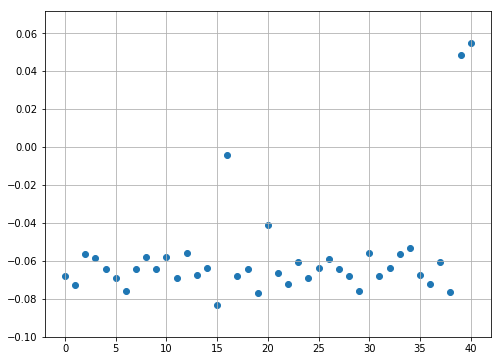

In [27]:
b.dropna(how = 'any', inplace=True)
b.reset_index(drop=True, inplace=True)

outliers, o_factors = GreedyWeightedEntropy(b)
print(outliers)
fig = plt.figure(figsize=(8,6))
plt.scatter(b.index, o_factors)
plt.grid()

In [ ]:
savefig('foo.png', bbox_inches='tight')

(array([], dtype=int64),)


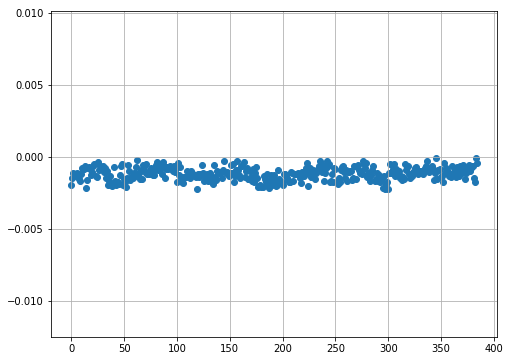

In [24]:
c.dropna(how = 'any', inplace=True)
c.reset_index(drop=True, inplace=True)

outliers, o_factors = GreedyWeightedEntropy(c)
print(outliers)
fig = plt.figure(figsize=(8b,6))
plt.scatter(c.index, o_factors)
plt.grid()

(array([  0,  16,  20,  26,  30,  38,  40,  42,  46,  48,  50,  52,  54,
        56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,  80,
        82,  96,  98, 114, 128, 136, 138, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 178, 180, 194,
       206, 208, 218, 220, 222, 226, 228, 234, 236, 240, 242, 244, 246,
       248, 250, 254, 256, 258, 260, 262, 264, 266, 270, 272, 274, 276,
       278, 290, 292, 304, 324, 326, 334, 338, 340, 344, 346, 348, 350,
       352, 354, 356, 358, 360, 362, 364, 366, 370, 372, 374, 376, 390,
       392, 402, 404, 406, 408, 412, 414, 416, 418, 420, 422, 428, 430,
       432, 434, 436, 438, 440, 442, 444, 446, 448, 450, 452, 454, 456,
       458, 460, 462, 464, 466, 468, 470, 472, 474, 476, 486, 488],
      dtype=int64),)


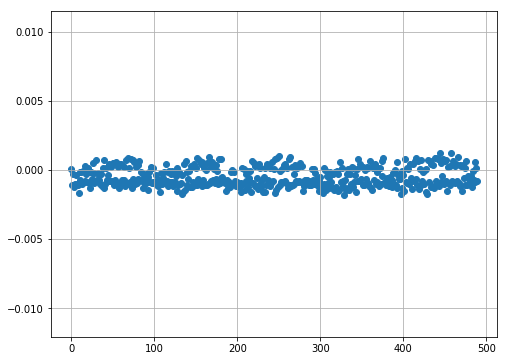

In [23]:
d.dropna(how = 'any', inplace=True)
d.reset_index(drop=True, inplace=True)

outliers, o_factors = GreedyWeightedEntropy(d)
print(outliers)
fig = plt.figure(figsize=(8,6))
plt.scatter(d.index, o_factors)
plt.grid()

(array([ 24,  25,  35,  36,  38,  41,  42,  47,  50,  53,  55,  56,  59,
        61,  68,  69,  70,  72,  74,  77,  78,  79,  81,  82,  92, 118,
       119, 121, 122, 123, 124, 125, 126, 132, 133, 134, 135, 136, 137,
       138, 140, 141, 143, 145, 146, 148, 149, 150, 151, 152, 154, 156,
       160, 161, 162, 163, 166, 168, 170, 173, 174, 176, 178, 179, 181,
       183, 187, 188, 195], dtype=int64),)


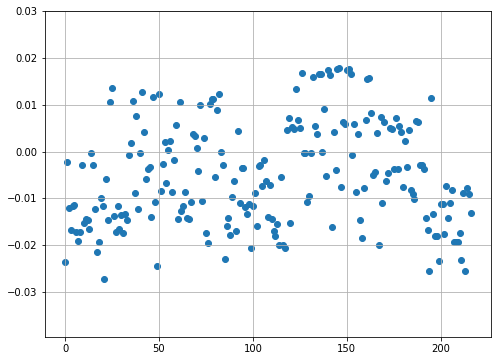

In [22]:
e.dropna(how = 'any', inplace=True)
e.reset_index(drop=True, inplace=True)

outliers, o_factors = GreedyWeightedEntropy(e)
print(outliers)
fig = plt.figure(figsize=(8,6))
plt.scatter(e.index, o_factors)
plt.grid()